In [4]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
import wfdb
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# Ensure deterministic behavior for TF on GPU
if tf.test.is_gpu_available():
    tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
    tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')
    tf.config.gpu.set_per_process_memory_growth(True)
    tf.config.gpu.set_per_process_memory_fraction(0.5)
    tf.config.set_soft_device_placement(True)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# List of record names to process
record_names = ['201', '202', '203', '219', '221', '222']

# Annotations to consider ('A', 'a', 'J', 'S')
considered_annotations = ['A', 'a', 'J', 'S']

# Initialize empty lists to store data from multiple records
all_segments = []
all_labels = []

for record_name in record_names:
    # Load the MIT-BIH arrhythmia dataset
    record = wfdb.rdrecord(record_name, channels=[0])

    # Extract the ECG signal and the corresponding annotations
    ecg_signal = record.p_signal.flatten()
    annotations = wfdb.rdann(record_name, 'atr')

    # Downsample the signal to 250Hz
    original_sampling_rate = record.fs
    target_sampling_rate = 250
    downsampling_factor = original_sampling_rate // target_sampling_rate
    downsampled_signal = signal.decimate(ecg_signal, downsampling_factor)

    # Segment the filtered ECG signals into 4s segments with 1000 sample points
    segment_length = 4 * target_sampling_rate
    num_segments = len(downsampled_signal) // segment_length
    segmented_ecg = np.array_split(downsampled_signal[:num_segments * segment_length], num_segments)

    # Sort the segments according to annotations
    sorted_segments = [segment for _, segment in sorted(zip(annotations.sample, segmented_ecg))]

    # Normalize each ECG segment using Z-score normalization
    normalized_segments = [(segment - np.mean(segment)) / np.std(segment) for segment in sorted_segments]

    # If needed, you can convert the normalized segments back to a flat array
    normalized_ecg = np.concatenate(normalized_segments)

    # Convert annotations to binary labels (atrial flutter or not)
    binary_labels = np.array([1 if a in considered_annotations else 0 for a in annotations.symbol])

    # Ensure the lengths match by truncating or padding 'normalized_segments'
    min_samples = min(len(normalized_segments), len(binary_labels))
    normalized_segments = normalized_segments[:min_samples]
    binary_labels = binary_labels[:min_samples]

    # Append data to the lists
    all_segments.extend(normalized_segments)
    all_labels.extend(binary_labels)

# Convert lists to arrays
X_all = np.array(all_segments)
y_all = np.array(all_labels)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=seed_value)
X_resampled, y_resampled = smote.fit_resample(X_all, y_all)

# Shuffle the data
shuffle_indices = np.arange(X_resampled.shape[0])
np.random.shuffle(shuffle_indices)
X_shuffled = X_resampled[shuffle_indices]
y_shuffled = y_resampled[shuffle_indices]

# Split data into training and testing sets
train_size = int(0.8 * X_shuffled.shape[0])
X_train, X_test = X_shuffled[:train_size], X_shuffled[train_size:]
y_train, y_test = y_shuffled[:train_size], y_shuffled[train_size:]

# Reshape the data for the CNN model
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Define the model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(segment_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Predict on the test set
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate metrics
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print metrics
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')

# Print confusion matrix
cm = confusion_matrix(y_test, binary_predictions)
print('Confusion Matrix:')
print(cm)

# Extract values from confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

# Print accuracy, specificity, and sensitivity
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test Specificity: {specificity * 100:.2f}%')
print(f'Test Sensitivity: {sensitivity*100:.2f}%')

Epoch 1/10
156/156 [==============================] - 8s 45ms/step - loss: 0.0646 - accuracy: 0.9748 - val_loss: 0.0100 - val_accuracy: 0.9984
Epoch 2/10
156/156 [==============================] - 7s 44ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0048 - val_accuracy: 0.9984
Epoch 3/10
156/156 [==============================] - 7s 44ms/step - loss: 1.8671e-04 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 0.9984
Epoch 4/10
156/156 [==============================] - 7s 42ms/step - loss: 1.0509e-04 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9984
Epoch 5/10
156/156 [==============================] - 6s 40ms/step - loss: 6.7561e-05 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 0.9984
Epoch 6/10
156/156 [==============================] - 6s 40ms/step - loss: 4.8192e-05 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 0.9984
Epoch 7/10
156/156 [==============================] - 6s 40ms/step - loss: 3.5236e-05 - accuracy: 1.0000 - val_loss: 0.0048 - 

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,binary_predictions, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       770
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1552
   macro avg       1.00      1.00      1.00      1552
weighted avg       1.00      1.00      1.00      1552



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


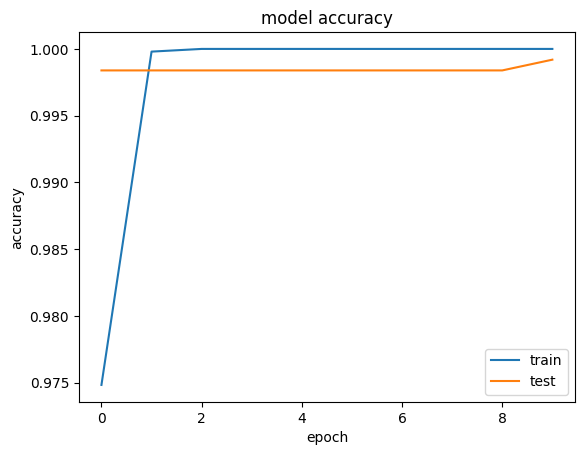

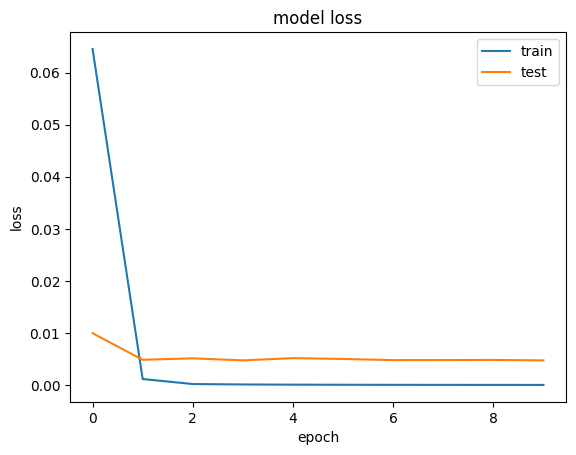

In [6]:
import matplotlib.pyplot as plt
# history = model.fit(X_test, y_test, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig('Accuracy AFL.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('Loss AFL.png')
plt.show()